# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

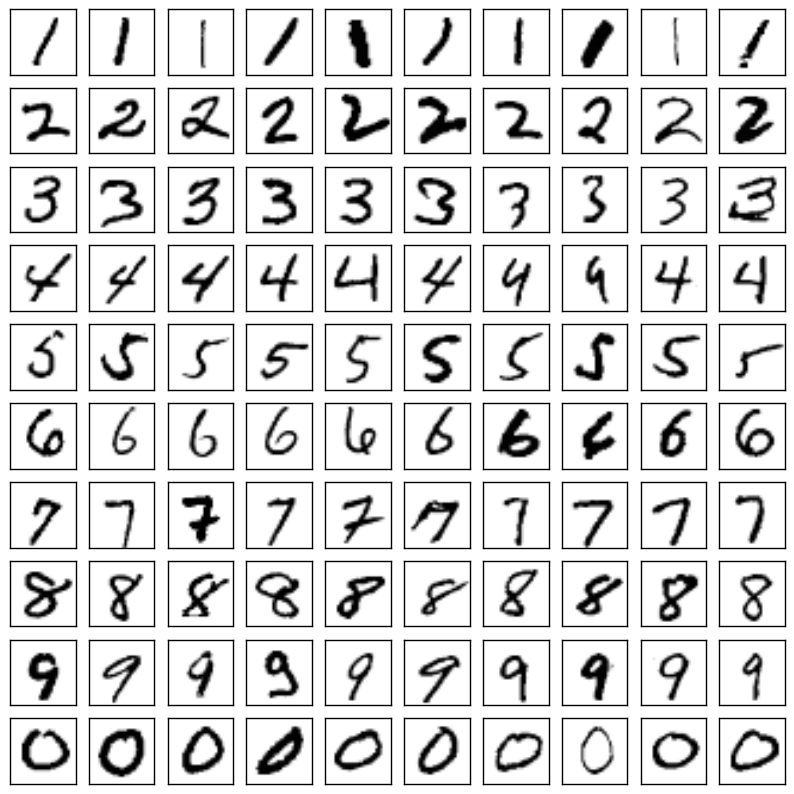

In [11]:
### STUDENT START ###

def P1(num_examples=10):
    plt.rc('image', cmap = 'Greys') # Set color mapping
    plt.figure(figsize=(10,10)) # Set plot size
    
    # To be done for each digit from 0 to 9
    for digit in range(1,11):     
        col = 1 # Set column to 1, will be incremented by 1 each iteration
        for j in (np.where(Y==digit%10)[0][0:num_examples]):
            Ax=plt.subplot(10,10,((digit-1)*num_examples) + col)
            PlotMatrix=np.reshape(X[j,:],newshape=(28,28))
            plt.imshow(PlotMatrix)
            ax = plt.gca()
            # ax.set_axis_off() # Also hide axes (frame) 
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            col += 1
            
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [15]:
### STUDENT START ###

def P2(k_values):
    for k in k_values:
        # Initialize the model
        knn_model = KNeighborsClassifier(n_neighbors = k)
        # Fitting the training data to training labels
        knn_model.fit(X = mini_train_data, y = mini_train_labels)
        # Predict the labels
        dev_pred = knn_model.predict(dev_data)
                
        # Checking accuracy
        
        print('Accuracy for k = {0:d} is: {1:.3f}'.format(k, knn_model.score(dev_data, dev_labels)))
        
        print(classification_report(dev_labels, dev_pred, target_names = None))
        
        
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy for k = 1 is: 0.888
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Accuracy for k = 3 is: 0.878
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95        99
        1.0       0.81      1.00      0.89       105
        2.0       0.95      0.81      0.88       102
        3.0       0.69      0.84      0.75        86
        4.0       0.88      0.85     

ANSWER: __The most difficult digit for this model is 9, based on F-score alone.  However, it should be noted that 3 consistently had the lowest precision score, while 2 had the lowest recall score.__

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [21]:
### STUDENT START ###

def P3(train_sizes, accuracies):
    nn = 1
    nn_model = KNeighborsClassifier(n_neighbors = nn)
    comp_time = []
    
    for size in train_sizes:
        start = time.time() # Get start time
        # Set training data and labels of approppriate size
        train_data, train_labels = X[:size], Y[:size]
        nn_model.fit(train_data, train_labels)
        accuracy = nn_model.score(dev_data, dev_labels)
        accuracies.append(accuracy)
        end = time.time() # Get end time
        tot_time = end - start
        comp_time.append(end - start) # record teh total computation time
        print('For Training size = {0:5d}: Accuracy = {1:.3f}, Comp Time = {2:4.2f}\n'.format(size, accuracy, tot_time) )


### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

For Training size =   100: Accuracy = 0.720, Elapsed time = 0.14

For Training size =   200: Accuracy = 0.786, Elapsed time = 0.24

For Training size =   400: Accuracy = 0.841, Elapsed time = 0.47

For Training size =   800: Accuracy = 0.884, Elapsed time = 1.02

For Training size =  1600: Accuracy = 0.902, Elapsed time = 2.03

For Training size =  3200: Accuracy = 0.926, Elapsed time = 4.09

For Training size =  6400: Accuracy = 0.937, Elapsed time = 8.49

For Training size = 12800: Accuracy = 0.959, Elapsed time = 18.12

For Training size = 25000: Accuracy = 0.970, Elapsed time = 39.63



(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [24]:
### STUDENT START ###

def P4(num_vals, accuracies):
    reg_mod = LinearRegression()
    train_vec = (np.array(train_sizes))[:,np.newaxis] # Converting train_sizes array from before to a vector
    reg_mod.fit(train_vec, accuracies) # Fitting accuracies to the training sizes
    print('Time Required for %i Training Points: %f' %(num_vals, reg_mod.predict(num_vals)))
    
    print('Intercept: %f' %(reg_mod.intercept_))
    print('Coeffecient: %f' %(reg_mod.coef_))
    
    # This is not a good model to use as the Y value can be > 1, 
    # which in this case wouldn't make sense as 1 is the max accuracy
    # Using log may be a better strategy
    
    reg_mod_log = LinearRegression()
    log_train = np.log(train_sizes)
    log_train_vec = (np.array(log_train))[:,np.newaxis]
    reg_mod_log.fit(log_train_vec, accuracies)
    
    print('Intercept: %f' %(reg_mod_log.intercept_))
    print('Coeffecient: %f' %(reg_mod_log.coef_))
    
    print('Accuracy for %i values using log: %f' %(num_vals, reg_mod_log.predict(np.log(num_vals))))
   

### STUDENT END ###

P4(60000, accuracies)

Time Required for 60000 Training Points: 1.243072
Intercept: 0.843156
Coeffecient: 0.000007
Intercept: 0.568815
Coeffecient: 0.042269
Accuracy for 60000 values using log: 1.033865


ANSWER:
__Predicted Accuracy for Linear Regression Model is 1.24
Predicted Accuracy for Linear Regression Model on log is 1.03__

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


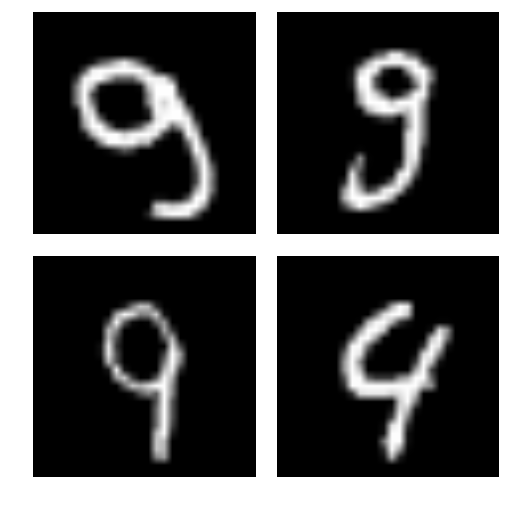

In [29]:
### STUDENT START ###

def P5():
    k = 1 # Since we are using 1-NN    
    mod = KNeighborsClassifier(k) # initialize our model
    mod.fit(mini_train_data, mini_train_labels)    
    pred = mod.predict(dev_data)

    # Confusion Matrix
    print(confusion_matrix(y_true = dev_labels, y_pred = pred, labels = range(10)))
    
    # Printing some examples.  In this case we'll do mislabeled 3's as 9's and 4's as 9's
          
    fig, ax = plt.subplots(2, 2, figsize=(6,6))
    
    nine_3, nine_4 = 0, 0 # aux for keeping track of examples plotted
    
    for i, label in enumerate(dev_labels):
        if label == 9:
            
            # 9 mislabeled as 3
            if pred[i] == 3 and nine_3 < 2:
                ax[0, nine_3].imshow(dev_data[i].reshape(28,28), cmap=plt.cm.gray)
                ax[0, nine_3].axis('off')
                nine_3 += 1

            # 9 mislabeled as 4
            if pred[i] == 4 and nine_4 < 2:
                ax[1, nine_4].imshow(dev_data[i].reshape(28,28), cmap=plt.cm.gray)
                ax[1, nine_4].axis('off')
                nine_4 += 1
            
            if nine_3 + nine_4 >= 4:
                break

    fig.subplots_adjust(wspace=.1, hspace=.1) 
    
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

ValueError: 'norm' must be an instance of 'mcolors.Normalize'

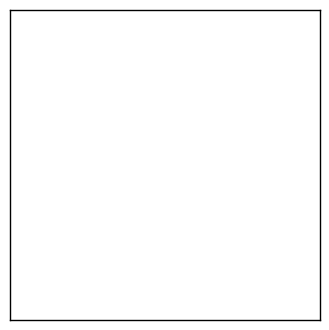

In [7]:
## STUDENT START ###

def P6():

    #Blurring the image
    def gaus_blur(image, sigma):
        dim = int(np.sqrt(len(image)))
        # make copy of original image
        blurry = np.copy(image)
        coordinates =np.zeros((dim,dim,2))        
        for i in range(coordinates.shape[0]):
            for j in range(coordinates.shape[1]):
                coordinates[i,j,0]= i
                coordinates[i,j,1]= j            
        # Get the 9 nearest neighbors to a pixel
        nine_neighbors = KNeighborsClassifier(9)
        nine_neighbors.fit(np.concatenate(coordinates), np.zeros(dim*dim))
        # For each pixel in the image
        for row in range(dim):
            for col in range(dim):
                # 9 nearest neighbors and their distances from the pixel in question
                neighbors = nine_neighbors.kneighbors([row, col])
                weights = np.exp(-(np.square(neighbors[0])) / (2*np.square(sigma)))/(2*np.pi*np.square(sigma))
                # Sum of weights = 1
                weights = weights/weights.sum()
                # Create the blurred image as a weighted combination of the original value and the 8 neighboring values
                blurry[row*dim+col] = np.average(image[neighbors[1]], weights=weights.tolist())
        return blurry
    
    # Blurring a random image
    dim = int(np.sqrt(X.shape[1]))
    rand_image = X[np.random.choice(X.shape[0])]
    plt.rc('image', cmap='Greys')
    plt.figure(figsize=(8, 4), dpi=X.shape[1])
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(rand_image, dim, dim)
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.imshow(rand_image, dim, dim)
    
    # Create a 1NN model
    knn_mod = KNeighborsClassifier(n_neighbors=1)
    # Blur both sets (with sigma=1)
    blurred_train_data = np.apply_along_axis(gaus_blur, 1, mini_train_data, 1)
    blurred_dev_data = np.apply_along_axis(gaus_blur, 1, dev_data, 1)
    # Take a look at 4 possible outcomes
    NN_model.fit(mini_train_data, mini_train_labels)
    print('Unprocessed Dev & Unprocessed Training Accuracy: {0:5.3f}'.format(NN_model.score(dev_data, dev_labels)))
    NN_model.fit(blurred_train_data, mini_train_labels)
    print('Unprocessed Dev & Preprocessed Training Accuracy: {0:7.3f}'.format(NN_model.score(dev_data,dev_labels)))                                                                                          
    NN_model.fit(mini_train_data, mini_train_labels)
    print('Preprocessed Dev & Unprocessed Training Accuracy: {0:7.3f}'.format(NN_model.score(blurred_dev_data, dev_labels)))                                                                                                    
    NN_model.fit(blurred_train_data, mini_train_labels)
    print('Preprocessed Dev & Preprocessed Training Accuracy: {0:9.3f}'.format(NN_model.score(blurred_dev_data, dev_labels)))
    
    ### STUDENT END ###

P6()

ANSWER: __In this case it can be seen that blurring works best when blurring (preprocessing) both the training and dev data.  This is because the preprocessing step helps to generalize both sets of images more, as some of the features (pixels) become more muddled (or blurred if you will) so that the risk of overfitting to training data is decreased. __

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [9]:
### STUDENT START ###

  
def tertiarize_pixels(data, thresholds=[0.3, 0.6]):
    # Make new array same shape as original
    tertiarized_data = np.zeros(data.shape)

    # Apply the tertiarize function
    for feature in range(data.shape[1]):
        tertiarized_data[:,feature] = data[:,feature] > thresholds[0]
        tertiarized_data[:,feature] = tertiarized_data[:,feature] + (data[:,feature] > thresholds[1])
    return tertiarized_data

def P7():
    # Set alpha to 1 for now
    alpha=1
    bnb_mod = BernoulliNB(alpha = alpha, binarize=0.5)
    bnb_mod.fit(train_data, train_labels)
    print('Bernoulli Naive Bayes accuracy: %3.2f' %bnb_mod.score(dev_data, dev_labels))

    # Let's try the same model on preprocessed (tertiarized) training data
    Tert_traindata = tertiarize_pixels(train_data)
    prep_bnb_mod = MultinomialNB(alpha=alpha, class_prior=None, fit_prior=True)
    prep_bnb_mod.fit(Tert_traindata, train_labels)
    Tert_devdata = tertiarize_pixels(dev_data)
    print('Multinomial Naive Bayes accuracy: %f' %(prep_bnb_mod.score(Tert_devdata, dev_labels)))


    
### STUDENT END ###

P7()

Bernoulli Naive Bayes accuracy: 0.84
Multinomial Naive Bayes accuracy: 0.824000


ANSWER: __Tertiarizing the data so that the pixels only have one of three values decresaed the accuracy.  This may be due to the fact that the images in question are relatively simple - as in there is not a lot of detail to numerals since they are neither particularly complex in shape nor rely on variations in pressure to create (which would result in different colors in each pixel).  Instead, what may have occurred here is that the model overfit to the training data.__  

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [10]:
### STUDENT START ###

def P8(alphas):
    grid_search = GridSearchCV(BernoulliNB(binarize=.5), alphas)
    grid_search.fit(mini_train_data, mini_train_labels)
    return grid_search

    ### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

In [14]:
print(nb.best_params_)
print('\n')
print(nb.grid_scores_)

{'alpha': 0.01}


[mean: 0.09200, std: 0.00080, params: {'alpha': 0.0}, mean: 0.81800, std: 0.02216, params: {'alpha': 0.0001}, mean: 0.82000, std: 0.02073, params: {'alpha': 0.001}, mean: 0.82100, std: 0.01811, params: {'alpha': 0.01}, mean: 0.81500, std: 0.02013, params: {'alpha': 0.1}, mean: 0.80000, std: 0.01188, params: {'alpha': 0.5}, mean: 0.79500, std: 0.01145, params: {'alpha': 1.0}, mean: 0.78400, std: 0.01934, params: {'alpha': 2.0}, mean: 0.72000, std: 0.02495, params: {'alpha': 10.0}]


ANSWER: __Best value is alpha = .01, while the alpha = 0 yields a super low accuracy.  This implies that the P(x) is more reliable then P(x|y), which in this case could make sense as there are a number of pixels (features) that don't have any values in numerous instances__.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

GuassianNB on unprocessed data: 62.1%
GaussianNB on preprocessed data: 82.6%


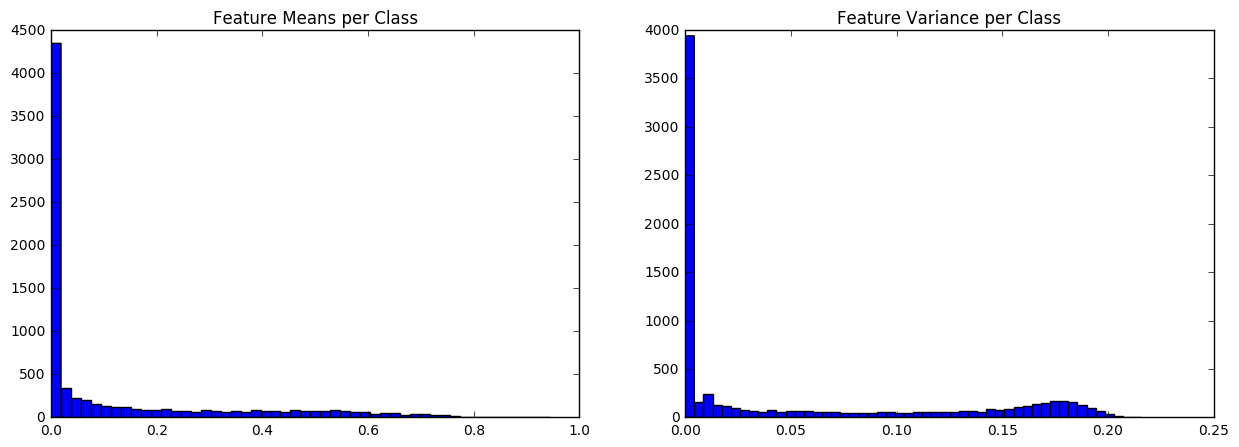

In [17]:
### STUDENT START ###

def P9():
    gnb_mod = GaussianNB()
    gnb_mod.fit(mini_train_data, mini_train_labels)
    print('GuassianNB on unprocessed data: {}%'.format(gnb_mod.score(dev_data, dev_labels)*100))

    # Not a great accuracy, let's plot it
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(gnb_mod.theta_.flatten(), 50)
    plt.title("Feature Means per Class")
    plt.subplot(1,2,2)
    plt.hist(gnb_mod.sigma_.flatten(), 50)
    plt.title("Feature Variance per Class")

    # Try it with preprocessed data - adding some noise
    proc_mini_train_data = (mini_train_data + np.random.uniform(size = mini_train_data.shape))
    proc_dev_data = (dev_data + np.random.uniform(size = dev_data.shape))
    proc_gnb_mod = GaussianNB()
    proc_gnb_mod.fit(proc_mini_train_data, mini_train_labels)
    print('GaussianNB on preprocessed data: {}%'.format(proc_gnb_mod.score(proc_dev_data, dev_labels)*100))
  
    ### STUDENT END ###

P9()

ANSWER:__Similar to what we saw in the blurring example, we notice that the accuracy of the model isn't that great for unprocessed data, but is signicantly better on processed training data.  This is because, unprocessed, many pixels have a stdev of 0 (as there is a lot of blank space and thus many zero values...leading to low variance), which isn't ideal for the GaussianNB.  By adding the noise, we are effectively increasing the variance, which leads to greater accuracy.__

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

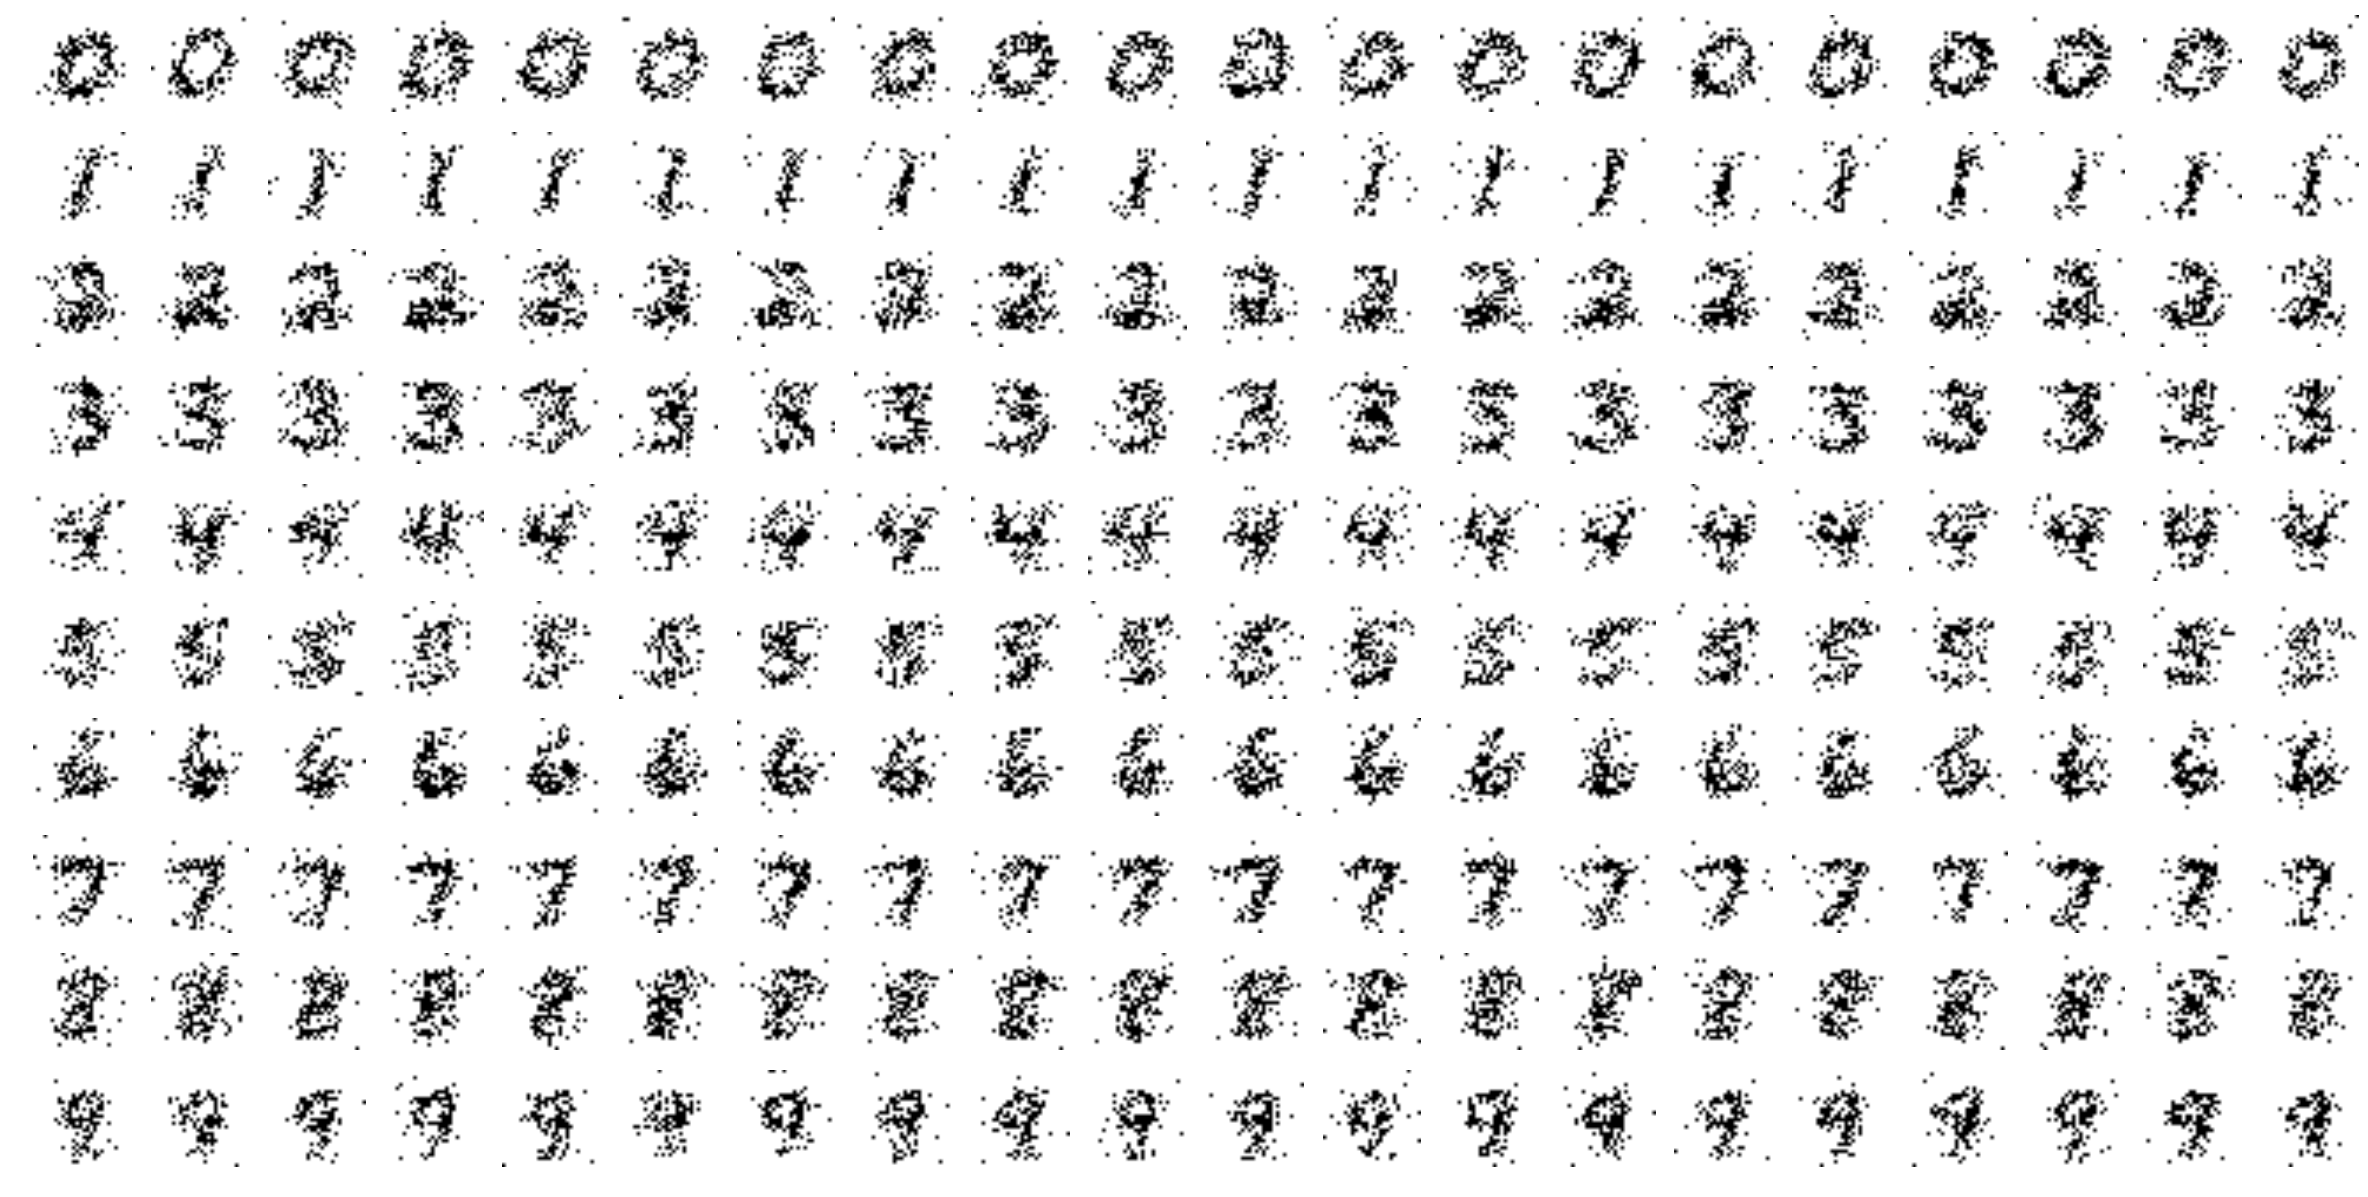

In [18]:
### STUDENT START ###

def P10(num_examples):
    # Initiliaze BNB object
    air_bnb = BernoulliNB(alpha=1, binarize=0.5)
    # Fitting
    air_bnb.fit(mini_train_data,mini_train_labels)
    # Concert log porbability back to probability
    Prob = np.exp(air_bnb.feature_log_prob_)

    plt.figure(figsize=(30,30))
    
    # Iterate for digits 0 - 9
    for digit in range(0,10):
        # For each samples in data
        for i in range(0,num_examples):
            # Determing binary yes/no for each pixel
            createddigit = Prob[digit,] > np.random.rand(1,784)
            Ax=plt.subplot(20,20,i+1+(20*digit))
            dig_matrix=np.reshape(createddigit[0,:],newshape=(28,28))
            plt.imshow(dig_matrix)
            plt.axis('off')
    plt.show()

    ### STUDENT END ###

ojbThing = P10(20)

ANSWER: __FIrst things first the creation of digits is super cool. While all the digits are at least recognizable, there is a considerable amount of noise in each one.__

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [22]:
### STUDENT START ###

def P11(buckets, correct, total):

    water_bnb = BernoulliNB(alpha=0.01, binarize=.5, fit_prior=False)
    water_bnb.fit(mini_train_data , mini_train_labels)
    pred_prob = np.exp(water_bnb.predict_log_proba(dev_data) )
    
    post_prob = np.max(pred_prob, axis=1)
    pred_label = np.argmax(pred_prob, axis=1)
        
    # For each prediction
    for i, p in enumerate(post_prob):
        # For every posterior bucket
        for j, b in enumerate(buckets): 
            if p >= b:                
                total[j] += 1
                # If correct, then add to count
                if pred_label[i] == dev_labels[i]:
                    correct[j] += 1
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total = 1000    accuracy = 0.818
p(pred) <= 0.9000000000000    total = 970    accuracy = 0.837
p(pred) <= 0.9990000000000    total = 884    accuracy = 0.873
p(pred) <= 0.9999900000000    total = 798    accuracy = 0.901
p(pred) <= 0.9999999000000    total = 743    accuracy = 0.918
p(pred) <= 0.9999999990000    total = 682    accuracy = 0.931
p(pred) <= 0.9999999999900    total = 607    accuracy = 0.939
p(pred) <= 0.9999999999999    total = 529    accuracy = 0.953
p(pred) <= 1.0000000000000    total = 499    accuracy = 0.958


ANSWER: __As the accruacy increases with the posterior probability, we can say that the model is well calibrated__

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()